In [1]:
import numpy as np
from music21 import midi, note, stream, instrument, meter, key, tempo, chord
from music21 import duration as dur
from music21.note import Rest
import random


In [2]:
def play(score):
    # shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In [4]:
####
# 1. transitioning to the Bolero, adding notes using a metrical structure (will be used to progrssively
# replace the brownian noise in introduction)
####

# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open("Bolero-Ravel_Flute_Bat_Strings.mid")
mf.read()
mf.close()
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))

# stream to accumulate the midi parts
new_stream = stream.Stream()

# time sig and tempo
ts = meter.TimeSignature('3/4')
new_stream.append(tempo.MetronomeMark(number = 72))
new_stream.insert(0, ts)

# an instrument to play our score
new_stream.insert(0, instrument.Guitar())

# probabilities for each of the beats of the measure to be added (metrical structure)
initial_probabilities = np.array([3, 1, 2, 1, 2, 1], dtype = 'float32') / 10


# looping over the different parts
for parts in s:
    for part in parts:
        
        # accumulator for the duration of the notes encountered 
        duration = 0
        
        # creating a part with the right Time sig
        new_part = stream.Part()
        new_part.insert(0, ts)
        
        # reseting the probabilities for each part
        probabilities = initial_probabilities
        
        # on each note or rest
        for element in part.flat.notesAndRests[0:100]:
            
            # increasing the probabilities once each two measures
            elem_duration = element.duration.quarterLength
            if (duration + elem_duration >= 6):
                probabilities *= 1.3
                
            # getting the new accumulated duration
            duration = (duration + elem_duration) % 6
            
            # adding the current note with a particular probability
            # or substituting it by a rest of same duration
            if (random.random() < probabilities[int(duration)] * elem_duration):
                new_part.append(element)
            else:
                r = note.Rest()
                r.duration = element.duration
                new_part.append(r)
                
        # inserting the part
        new_stream.insert(0, new_part)
        

In [5]:
new_stream.show()

In [6]:
#play(new_stream)

In [7]:
import matplotlib.pyplot as plt

In [110]:
TIMESTEPS = 1000
TIME_HORIZON = 700.0

In [111]:
def brownian_motion(dimensions=1, start_value = 0, time_horizon=TIME_HORIZON, timesteps= TIMESTEPS):

    times = np.linspace(0.0, time_horizon, timesteps)
    step_length = times[1] - times[0]

    # as brownian motion at time t1 - brownian motion at time t0 ~ Normal(mean = 0, variance = t1-t0)
    # scale is the standard deviation, so we take the square root of the step_length
    diff_b = np.random.normal(size = (timesteps-1, dimensions), scale = np.sqrt(step_length)) 

    brownian_motion = np.zeros(shape=(timesteps,dimensions))
    brownian_motion[0,:] = np.full((1, dimensions), start_value)

     # the rest of the values of brownian motion are the cumulative sum of normal values
    brownian_motion[1:,:] = np.cumsum(diff_b, axis = 0) + start_value

    #brownian_motion = np.cumsum(diff_b).append(0)
    return times, brownian_motion, diff_b

<function matplotlib.pyplot.show(close=None, block=None)>

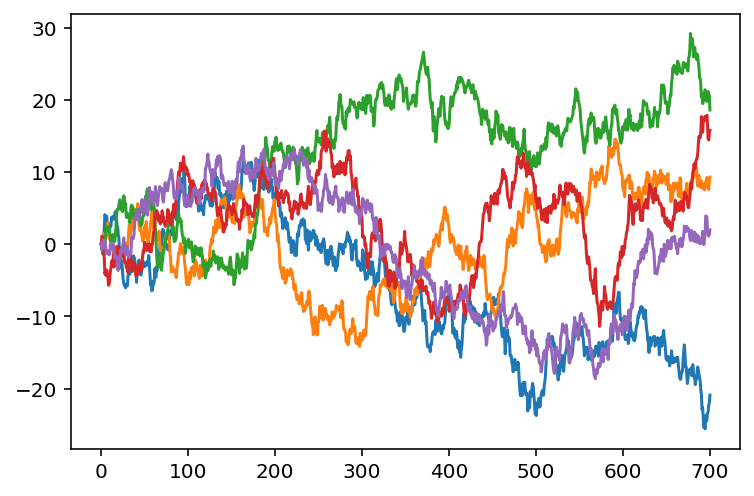

In [112]:
times, brownian_motion_arr, diff_brownian_motion = brownian_motion(dimensions=5)
plt.plot(times, brownian_motion_arr)
plt.show

In [113]:
diff_brownian_motion

array([[-0.30148262,  0.2941253 , -0.44893888,  1.1010361 , -0.77298967],
       [-0.43748541, -0.1478067 , -0.35627834, -0.02558058,  0.2283292 ],
       [ 0.5543694 , -0.01979651, -0.6132109 , -0.84328475,  1.16898018],
       ...,
       [ 1.11298808, -0.47573603, -0.69592962, -0.16762772, -0.34192177],
       [ 0.15528825,  1.05736695,  0.13334531,  0.9774982 ,  0.23102141],
       [ 1.14175785,  0.66875074, -2.00785684,  0.35635194,  0.6337592 ]])

In [153]:
####
# 2. removing (sporadically) rhythmic values & melodic attributes, restrain range down to dissonance
####

# Note to which we converge : E4
MI_PITCH = 64

# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open("Bolero-Ravel_Loop.mid")
mf.read()
mf.close()
s1 = stream.Stream()
s1.append(midi.translate.midiFileToStream(mf))

# stream to accumulate the midi parts
new_stream1 = stream.Stream()

# time sig and tempo
ts = meter.TimeSignature('3/4')
new_stream1.append(tempo.MetronomeMark(number = 72))
new_stream1.insert(0, ts)

# an instrument to play our score
new_stream1.insert(0, instrument.Guitar())


# getting the arrays of brownian motion
_,_, diff_brownian_motion = brownian_motion(dimensions = len(mf.tracks))


# looping over the different parts
for parts in s1:
    # and getting the corresponding brownian motion array
    for part, single_brownian_motion in zip(parts, diff_brownian_motion.transpose()):

        # creating a part with the right Time sig
        new_part = stream.Part()
        new_part.insert(0, ts)
        
        # to shift the array on each iteration
        index = 0
        
        # looping five times on the same two measures
        for _ in range(5):
            for element in part.flat.notesAndRests:
                
                # shifting the array
                move = single_brownian_motion[index]
                index += 1
                
                # if the brownian motion goes up and the length is smaller than two
                # we increase the duration of the element
                elem_duration = element.duration.quarterLength
                if (elem_duration < 2 and move >= 0):
           
                    new_elem_duration = round((elem_duration + move) * 4) / 4
                    element.duration = dur.Duration(quarterLength = new_elem_duration)
                
                # if the brownian motion is more than -1, we add the element
                # otherwise it is lost (to simplify the rythm)
                elif (move >= -1):
                    
                    # if the element is a chord, no new modifications occur, we add it
                    if(element.isClassOrSubclass((chord.Chord,))):
                        c = chord.Chord(element.notes, duration = element.duration)
                        new_part.append(c)
                    else:
                        
                        # if the element is a rest, no new modifications occur, we add it
                        if(element.name == 'rest'):
                            r = note.Rest(duration = element.duration)
                            new_part.append(r)
                        else:
                            
                            # if element is a note, we shift it's pitch towards E4 (convergence note)
                            elem_pitch = element.pitch.midi
                            to_add = 0
                            if (elem_pitch < MI_PITCH):
                                to_add = 1
                            elif (elem_pitch > MI_PITCH):
                                to_add = -1
                            
                            element.pitch.midi = elem_pitch + to_add
                            n = note.Note(duration = element.duration, pitch = element.pitch)
                            new_part.append(n)
                            
        # inserting the part
        new_stream1.insert(0, new_part)



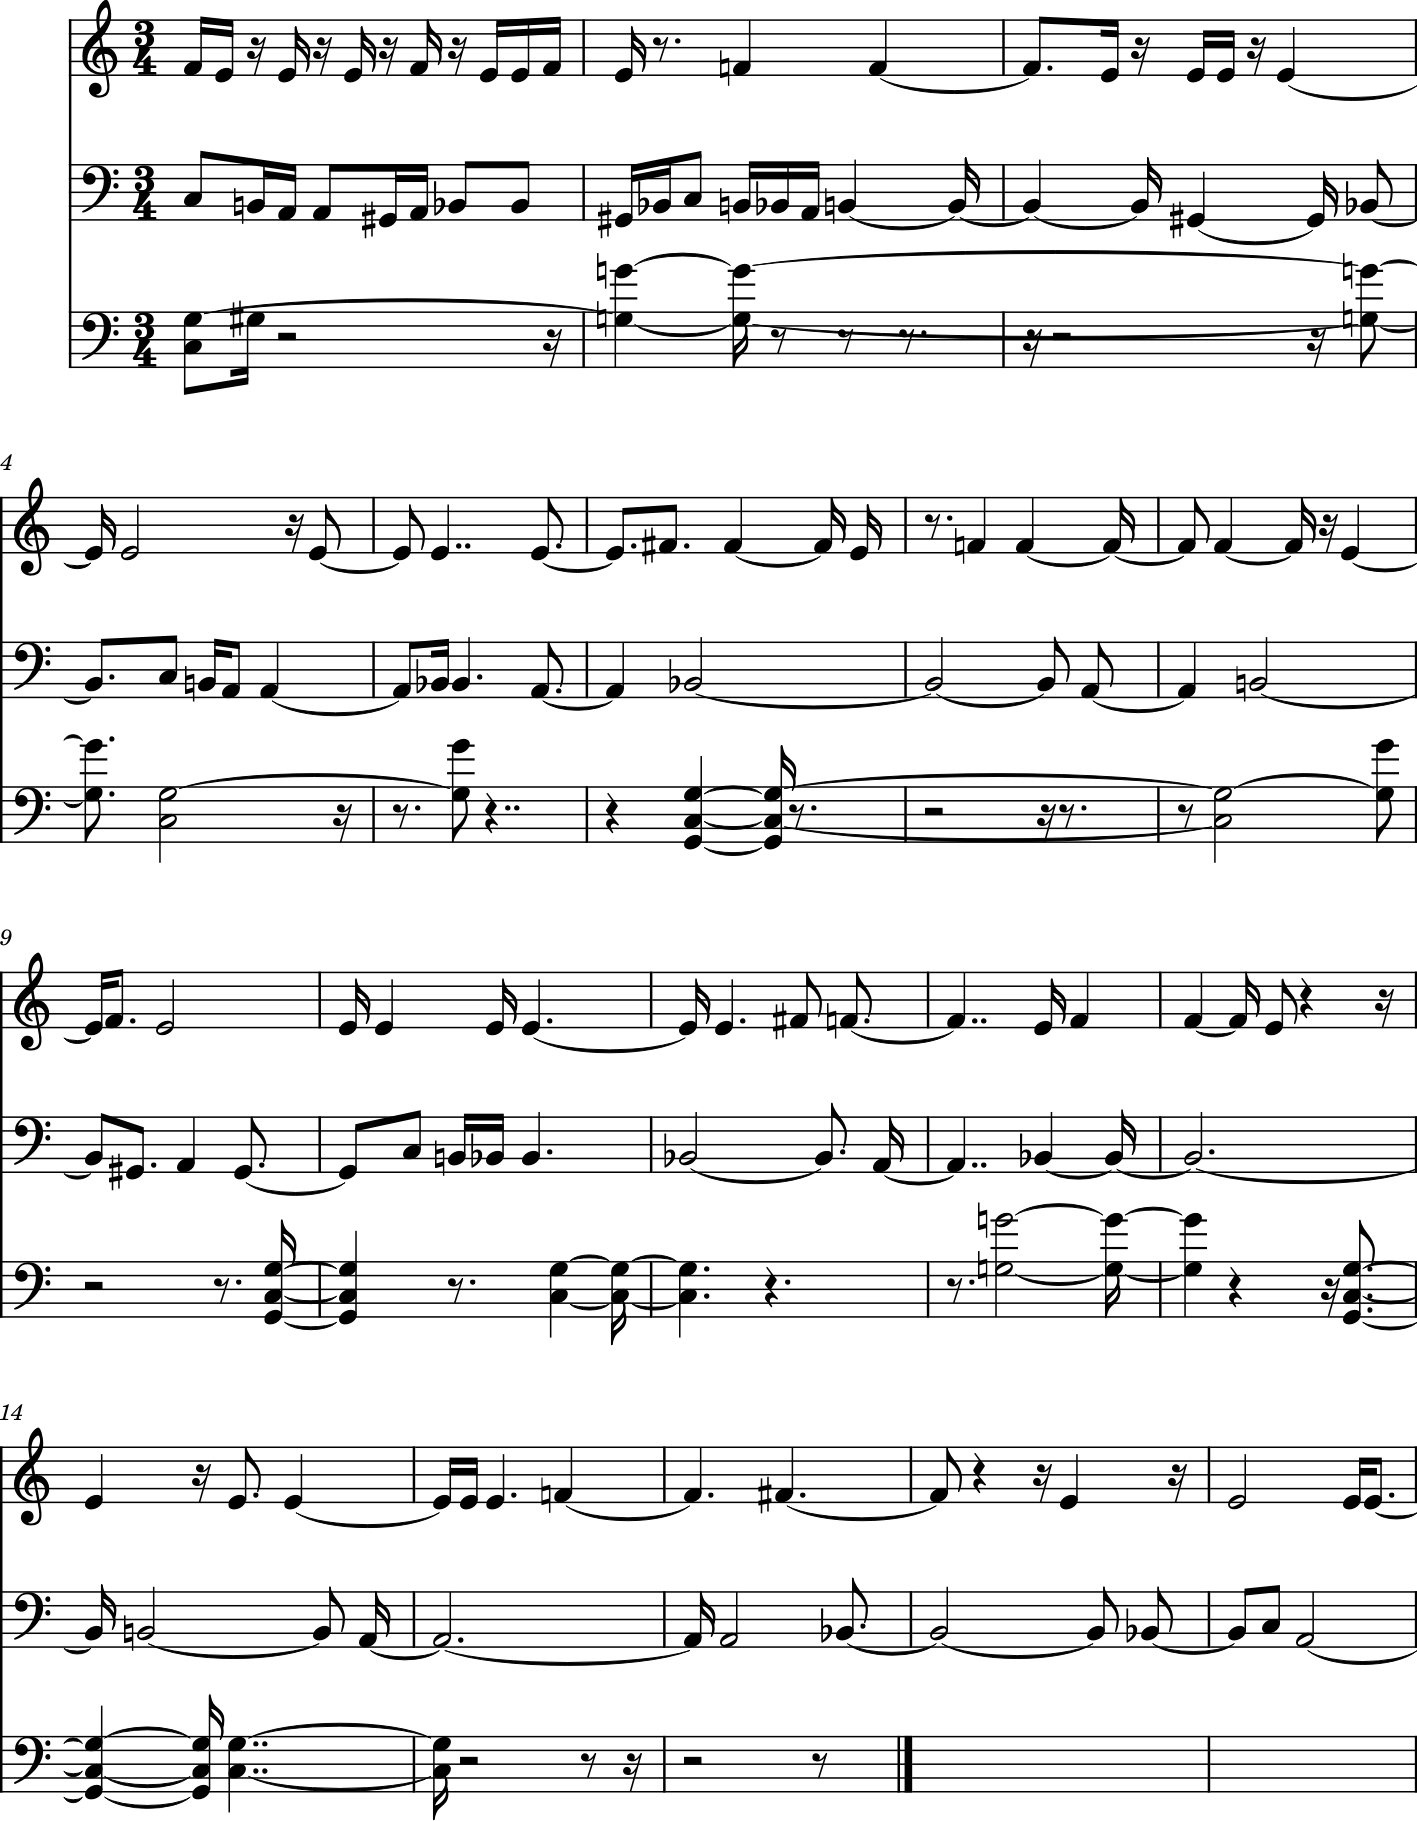

In [154]:
new_stream1.show()

In [152]:
play(new_stream1)